In [1]:
from __future__ import print_function
import sys,os

import numpy as np
from scipy.stats import hypergeom # ,fisher_exact
from fisher import pvalue
import pandas as pd
 
import networkx as nx
print("NetworkX version",nx.__version__, file = sys.stderr) # should be < 2
import ndex2.client
import ndex2

import itertools
import warnings
import time
import copy
import random

import matplotlib
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import axes3d 
import seaborn as sns

%matplotlib inline

NetworkX version 1.11


In [2]:
sys.path.append(os.path.abspath("/home/olya/SFU/Breast_cancer/DESMOND/"))
from method import prepare_input_data, print_network_stats
from method import precompute_RRHO_thresholds


In [3]:
########################## Input paramethers ############
# the direction of dysreguation
direction = "UP" # "UP"  or "DOWN" 

# exprssoin matrix -- with standardized expression values
exprs_file = "TCGA_micro_nolog2.z.13K_common.tsv"#"METABRIC_micro_nolog2.z.13K_common.tsv"#"TCGA_RNAseq.RSEM.log2.z.13K_common.tsv"#
exprs_dir = "/home/olya/SFU/Breast_cancer/Expression/Harmonized_final/"
exprs_file =  exprs_dir + exprs_file 

# network -- must be in NDEX2 format 
netwroks_dir = "/home/olya/SFU/Breast_cancer/Networks/"
network_file = netwroks_dir + "BioGRID.cx" 

# seeds are optional and not used by default
with_seeds = False
if with_seeds:
    from RWR import create_subnetworks_from_seeds 
    seed_dir = "/home/olya/SFU/Breast_cancer/seed_genes/"
    seeds_file = seed_dir+"Somatic_drivers.seeds.txt"
    # if seeds provided, set RWR parameters 
    RWR_probability_thr = 0.001 # determines how large subnetworks will be; strongly depends on the network topology
    r = 0.3 # expected number of steps is 2.3 for r=0.3 a
    delta = 0.000001 # RWR tolerance 
    # read and preprocess input files: network, expressions and seeds
    exprs, network, seeds = prepare_input_data(exprs_file, network_file, seeds_file, verbose = True)
else: 
    # read and preprocess input files: network and expressions
    exprs, network = prepare_input_data(exprs_file, network_file, verbose = True)
    
# where to write the results
out_dir = "/home/olya/SFU/Breast_cancer/example_run/" # 
basename = "TCGA-micro"


# minimal number of patients in a module
min_n_patients = int(max(10,0.1*len(exprs.columns.values))) # set to nax(10, 10% of the cohort) 
# print("Fixed step for RRHO selected:", ,file =sys.stderr)
print("Mininal number of patients in a module:",min_n_patients ,file=sys.stderr)

# how to assign patients on edges
method = "RRHO" # "top_half" or "RRHO"
if method == "RRHO":
    # set RRHO parameters
    significance_thr=0.05
    fixed_step = int(max(1,0.02*len(exprs.columns.values))) # 5-10-20 ~15
    print("Fixed step for RRHO selected:", fixed_step, file =sys.stderr)                

if with_seeds:
    basename +="_r"+str(r)+"_T"+str(RWR_probability_thr)+"."+method+"_"+direction
else:
    basename +="."+method+"_"+direction
print("basename:", basename)


### Sampling parameters 
alpha = 0.1
beta_K = 1.0
max_n_steps  = 100
min_pletau_steps = 30

### Merging parameters 
min_SNR = 0.5
min_patient_overlap = 0.75 # at least 75 % of candidates 
allowed_SNR_decrease  = 0.1 # maximum allowed % of SNR decrease when merge two modules 
# -i.e. new module loses after merge no more than 10% of SNR 

Input:
 	expressions: 13361 genes x 529 patients; 
	network: 16702 genes, 258257 edges in 13 connected components: 
	seeds: 0
4592 network nodes without expressoin profiles and 78735 edges excluded
1251 genes absent in the network excluded from the expression matrix


basename: TCGA-micro.RRHO_UP


Processed Input:
 	expressions: 11959 genes x 529 patients; 
	network: 16702 genes  179514 edges in 2 connected components:
Mininal number of patients in a module: 52
Fixed step for RRHO selected: 10


In [4]:
print_network_stats(network, print_cc = True)

Undirected graph with 2 connected components; with 11959 nodes and 179514 edges;
Connected component 1 : 11956 nodes and 179512 edges
Connected component 2 : 3 nodes and 2 edges


In [5]:
if method == "RRHO":
     rrho_thresholds = precompute_RRHO_thresholds(exprs, fixed_step = fixed_step,significance_thr=significance_thr)

Precomputing RRHO thresholds 3.64189791679 s


### Step1. Assign pateints to nodes 
1. every node gets sorted expression profile
2. every edge gets an associated set of patients - up- or down- regulated by both genes 
    * method = "top_halves" - takes an intersection of top-50% of both lists
    * method = "RRHO" - applies Rank-rank hypergeometric overlap

### Step2.  Probabilistic clustering
 1. set initial conditions
 2. do sampling until convergenes or no more than max_n_steps
 3. get consensus module membership
 
### Step 3.  Post-processing

## <s>[Greedy BFS]<\s>
### <s>2. Search for connected components <\s>
<s>Greedily grows connceted components starting from edges witrh maximal number of patients <\s>

### <s>3 Optimize the resulting modules<\s>
    <s>- optimize
    - merge 
    - filter<\s>
        

In [9]:
from method import  expression_profiles2nodes, assign_patients2edges, save_subnetworks,load_subnetworks
from method import plot_patient_ditsribution_and_mask_edges, count_emtpy_edges, count_masked_edges, write_modules

In [10]:
network = expression_profiles2nodes(network, exprs, direction)
network = assign_patients2edges(network, method= method,
                                                    fixed_step=fixed_step,significance_thr=significance_thr,
                                                    rrho_thrs = rrho_thresholds)
print("Edges without patients:",count_emtpy_edges(network, thr = 0))

Genes in expression matrix (529, 11959)
expression_profiles2nodes()	runtime: 5.09767 s
	 1000 edges processed. Average runtime per edge: 0.006096119165420532
	 2000 edges processed. Average runtime per edge: 0.005978760838508606
	 3000 edges processed. Average runtime per edge: 0.006228507359822591
	 4000 edges processed. Average runtime per edge: 0.006300877869129181
	 5000 edges processed. Average runtime per edge: 0.006330322790145874
	 6000 edges processed. Average runtime per edge: 0.00628080960114797
	 7000 edges processed. Average runtime per edge: 0.006362632478986468
	 8000 edges processed. Average runtime per edge: 0.006377766817808151
	 9000 edges processed. Average runtime per edge: 0.006301684035195244
	 10000 edges processed. Average runtime per edge: 0.006244749808311462
	 11000 edges processed. Average runtime per edge: 0.006099294900894165
	 12000 edges processed. Average runtime per edge: 0.0060042222142219544
	 13000 edges processed. Average runtime per edge: 0.00602

	 114000 edges processed. Average runtime per edge: 0.005962078659158004
	 115000 edges processed. Average runtime per edge: 0.005963955443838368
	 116000 edges processed. Average runtime per edge: 0.00596476044325993
	 117000 edges processed. Average runtime per edge: 0.0059656462180308805
	 118000 edges processed. Average runtime per edge: 0.00596054274550939
	 119000 edges processed. Average runtime per edge: 0.005961597955527426
	 120000 edges processed. Average runtime per edge: 0.0059635545233885446
	 121000 edges processed. Average runtime per edge: 0.005964706074107777
	 122000 edges processed. Average runtime per edge: 0.005961483994468314
	 123000 edges processed. Average runtime per edge: 0.00596172230030463
	 124000 edges processed. Average runtime per edge: 0.0059668892756585155
	 125000 edges processed. Average runtime per edge: 0.005965861814498902
	 126000 edges processed. Average runtime per edge: 0.00596887373167371
	 127000 edges processed. Average runtime per edge: 

Edges without patients: 85035


In [11]:
# save subnetworks with assigned patients if necessary 
outfile_name =  out_dir + basename +".network.txt"
outfile_name

'/home/olya/SFU/Breast_cancer/example_run/TCGA-micro.RRHO_UP.network.txt'

In [12]:
print("edges masked:",count_masked_edges(network))
save_subnetworks([network], outfile_name)
#resulted_subnets = load_subnetworks(outfile_name)

edges masked: 0


save_subnetworks() runtime 23.38 s


edges 179514 edges masked: 94232


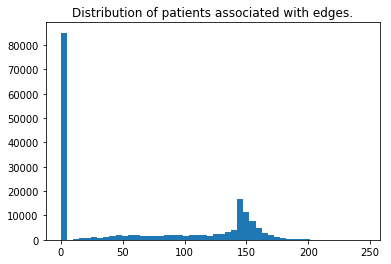

In [13]:
plot_patient_ditsribution_and_mask_edges(network,min_n_patients=min_n_patients,title="Distribution of patients associated with edges.")
print("edges",len(network.edges()),"edges masked:",count_masked_edges(network))

### 2. Sample module memberships

In [24]:
from method import  set_initial_distribution,sampling, get_consensus_module_membrship
from method import check_convergence_condition, restore_modules, get_genes, get_opt_pat_set
from post_processing import plot_bic_stats, write_modules, merge_modules

In [15]:
# initial distribution
edges, edgeNeighorhood, edge2module, moduleSizes,  edge2patients, nOnesPerPatientInModules = set_initial_distribution(network, exprs, basename, out_dir)

0.21 s runtime


0 edges processed
10000 edges processed
20000 edges processed
30000 edges processed
40000 edges processed
50000 edges processed
60000 edges processed
70000 edges processed
80000 edges processed


created TCGA-micro.RRHO_UP.edgeNeighorhood.npy file in 3402.59 s
0.0 s runtime


(85282, 529) (85282, 529)


7.97 s runtime


In [16]:
# sampling 
edge2module_history, edges_skip_history, edge2module_history_slice =  sampling(edges,  edgeNeighorhood, edge2module, edge2patients,  moduleSizes,nOnesPerPatientInModules, 
                                                                               max_n_steps=max_n_steps,alpha = alpha, beta_K = beta_K,min_pletau_steps = min_pletau_steps)

# save intermidiate results 
np.save(out_dir+basename+".edge2module_history.a="+str(alpha)+".b="+str(beta_K), edge2module_history)
np.save(out_dir+basename+".edges_skip_history.a="+str(alpha)+".b="+str(beta_K), edges_skip_history)
np.save(out_dir+basename+".edges.a="+str(alpha)+".b="+str(beta_K), edges)

step 1 n_changes 70454


453.7824 s runtime


step 2 n_changes 19039


9472.836 s runtime


step 3 n_changes 3449


246.9779 s runtime


step 4 n_changes 1096


241.9884 s runtime


step 5 n_changes 525


246.7314 s runtime


step 6 n_changes 330


235.4227 s runtime


step 7 n_changes 272


228.3514 s runtime


step 8 n_changes 213


233.9797 s runtime


step 9 n_changes 142


227.4384 s runtime


step 10 n_changes 127


209.1266 s runtime


step 11 n_changes 104


215.3563 s runtime


step 12 n_changes 97


224.5427 s runtime


step 13 n_changes 111


223.1693 s runtime


step 14 n_changes 92


226.7986 s runtime


step 15 n_changes 80


215.2937 s runtime


step 16 n_changes 70


217.7167 s runtime


step 17 n_changes 95


225.5108 s runtime


step 18 n_changes 99


213.2227 s runtime


step 19 n_changes 89


220.1708 s runtime


step 20 n_changes 95


216.2692 s runtime


step 21 n_changes 88


208.0355 s runtime


step 22 n_changes 85


211.3108 s runtime


step 23 n_changes 86


213.3185 s runtime


step 24 n_changes 72


209.4029 s runtime


step 25 n_changes 91


213.7916 s runtime


step 26 n_changes 86


210.9216 s runtime


step 27 n_changes 81


221.568 s runtime


step 28 n_changes 70


215.8177 s runtime


step 29 n_changes 82


213.3086 s runtime


step 30 n_changes 68


212.189 s runtime


step 31 n_changes 80


211.6656 s runtime


step 32 n_changes 78


221.7636 s runtime


step 33 n_changes 70


213.8128 s runtime


step 34 n_changes 55


213.4448 s runtime


step 35 n_changes 66


214.6743 s runtime


step 36 n_changes 68


226.8468 s runtime


step 37 n_changes 53


213.0194 s runtime
The model converged after 37 steps.


In [30]:
#edge2module_history = np.load(out_dir+basename+".edge2module_history.a="+str(alpha)+".b="+str(beta_K)+".npy")
#edges_skip_history = np.load(out_dir+basename+".edges_skip_history.a="+str(alpha)+".b="+str(beta_K)+".npy")
#edges = np.load(out_dir+basename+".edges.a="+str(alpha)+".b="+str(beta_K)+".npy")
#edge2module_history_slice = edge2module_history[-min_pletau_steps:]

In [18]:
# consensus edge-to-module membership
consensus_edge2module = get_consensus_module_membrship(edge2module_history_slice, edges)

	edge: 39418 counts: [10 12  8] 
	labels: 48487,63767,37273,37273,37273,37273,48487,48487,37273,48487,63767,48487,63767,48487,48487,37273,37273,63767,48487,63767,48487,63767,63767,63767,37273,37273,48487,48487,37273,48487


5.08 s runtime


empty modules: 74110 non-empty modules: 11172


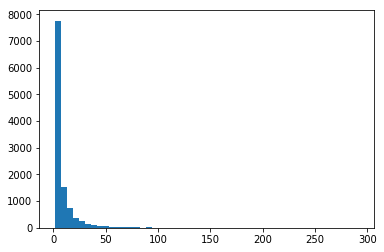

In [19]:
# make moduleSizes, nOnesPerPatientInModules corresponding to consensus module mebership 
moduleSizes, nOnesPerPatientInModules = restore_modules(consensus_edge2module,edges,network,exprs)

print("empty modules:", len([x for x in moduleSizes if x == 0]),
      "non-empty modules:",len([x for x in moduleSizes if x != 0]))
tmp = plt.hist(moduleSizes, bins=50, range=(1,max(moduleSizes)))

6862


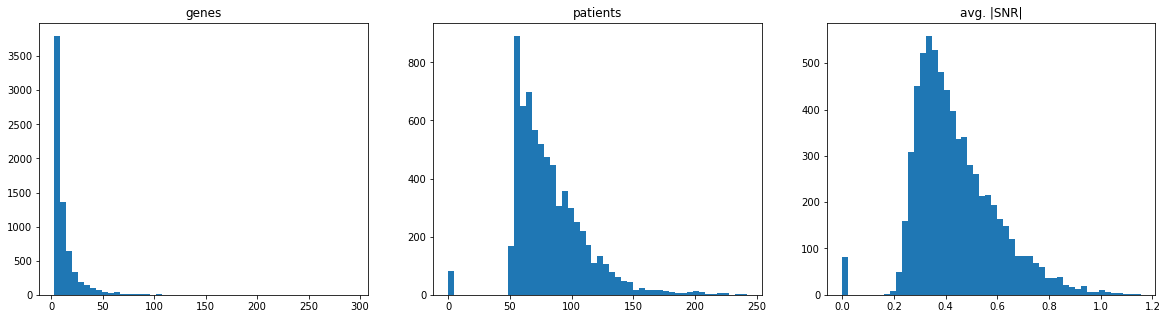

In [20]:
bics = []
for mid in range(0,len(moduleSizes)):
    if moduleSizes[mid]>1:
        genes = get_genes(mid,edge2module=consensus_edge2module,edges=edges)
        pats, thr, avgSNR = get_opt_pat_set(nOnesPerPatientInModules[mid,], moduleSizes[mid,],
                                            exprs, genes, min_n_patients=min_n_patients)
        bics.append({"genes":set(genes), "patients":set(pats), "avgSNR":avgSNR,"id":mid})


plot_bic_stats(bics)
print(len(bics))

### 3. Post-processing: Filter the resulting modules and do post-processing:
 * exclude all the modules with low SNR < 0.5
 * repeat until the list of modules is non-empty 
    * select module with maximal SNR
    * find all the candidates with at least 75% of mutual patinet ovelap and at least 1 gene shared
    * try merging with every candidate and calcuate new threshold with max. abs. SNR
    * select one with max SNR but with loss no more than 10 %
    * if any suitable candidates found - merge 
    * else save module and remove it from the list

In [21]:
#min_SNR = 0.5
#min_patient_overlap = 0.75 # at least 75 % of candidates 
#allowed_SNR_decrease  = 0.1 # maximum allowed % of SNR decrease when merge two modules 
# -i.e. new module loses after merge no more than 10% of SNR 

2008


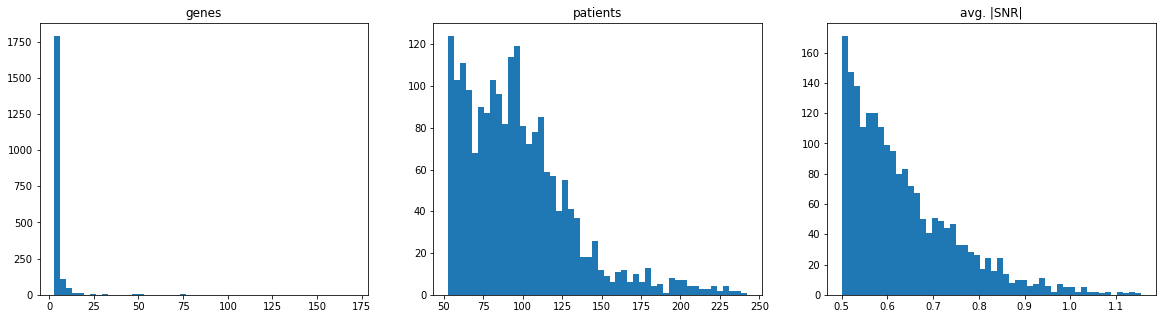

In [22]:
filtered_bics = []
for bic in bics:
    if bic["avgSNR"] > min_SNR:
        filtered_bics.append(copy.copy(bic))
plot_bic_stats(filtered_bics)
print(len(filtered_bics))

In [27]:
resulting_modules = merge_modules(filtered_bics, copy.copy(nOnesPerPatientInModules),copy.copy(moduleSizes),exprs,SNRs = [],
                              min_patient_overlap = min_patient_overlap,
                              min_acceptable_SNR_percent=1-allowed_SNR_decrease, verbose= False)

42.18 s runtime


0 module: 43260 SNR 1.089 pats 64 genes 49
1 module: 30997 SNR 1.076 pats 170 genes 7
2 module: 74677 SNR 1.059 pats 189 genes 3
3 module: 44997 SNR 1.025 pats 234 genes 3
4 module: 52472 SNR 1.02 pats 197 genes 3
5 module: 52764 SNR 1.01 pats 227 genes 3
6 module: 69856 SNR 1.005 pats 61 genes 8
7 module: 84081 SNR 1.001 pats 231 genes 4
15 module: 50466 SNR 1.006 pats 78 genes 15
1936


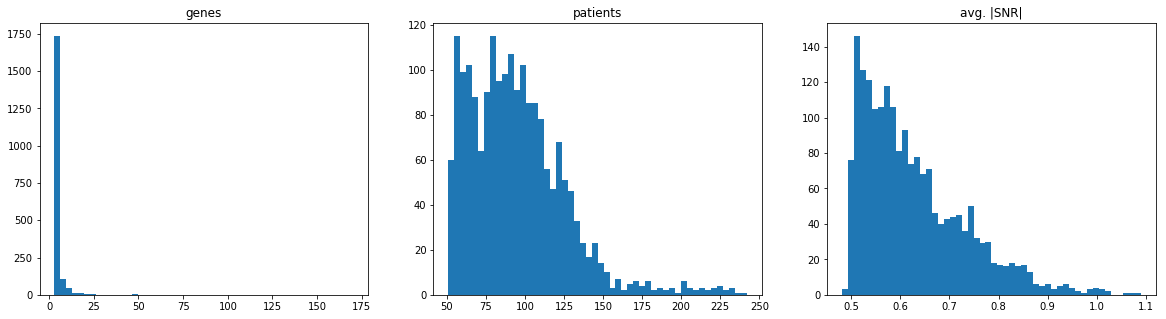

In [28]:
i=0
for bic in resulting_modules:
    if bic["avgSNR"]> 1.0:
        print(i,"module:",bic["id"],"SNR",bic["avgSNR"], "pats",len(bic["patients"]), "genes", len(bic["genes"]))
    i+=1
print(len(resulting_modules))
plot_bic_stats(resulting_modules)

In [29]:
def write_modules(bics,file_name):
    fopen = open(file_name,"w")
    for bic in bics:
        print("id:\t"+str(bic["id"]), file=fopen)
        print("average SNR:\t"+str(bic["avgSNR"]),file=fopen)
        print("genes:\t"+" ".join(bic["genes"]),file=fopen)
        print("patients:\t"+" ".join(bic["patients"]),file=fopen)
    fopen.close()
    print(str(len(bics)),"modules written to",file_name,file = sys.stderr)
    
file_name = out_dir+basename+".minSNR_"+str(min_SNR)+".modules.txt"
write_modules(resulting_modules,file_name)

1936 modules written to /home/olya/SFU/Breast_cancer/example_run/TCGA-micro.RRHO_UP.minSNR_0.5.modules.txt
